In [2]:
#!pip -q install ftfy regex tqdm scipy umap-learn
#!pip -q install git+https://github.com/openai/CLIP.git
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import STL10
import clip
from scipy.linalg import orthogonal_procrustes
import umap
from sklearn.manifold import TSNE

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [4]:
MODEL_NAME = "ViT-B/32"

model, preprocess = clip.load(MODEL_NAME, device=device)
model.eval()

def model_dtype(m: torch.nn.Module) -> torch.dtype:
    return next(m.parameters()).dtype

DTYPE = model_dtype(model)
print("CLIP model:", MODEL_NAME, "| dtype:", DTYPE)

CLASSNAMES = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

test_ds = STL10(root="./data", split="test", download=True, transform=preprocess)
BATCH_SIZE = 256
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("STL-10 test samples:", len(test_ds))

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 178MiB/s]


CLIP model: ViT-B/32 | dtype: torch.float32


100%|██████████| 2.64G/2.64G [03:09<00:00, 13.9MB/s]


STL-10 test samples: 8000


In [5]:
@torch.no_grad()
def extract_image_features(dataloader, model, device):
    feats_raw = []
    labels_all = []

    for images, labels in tqdm(dataloader, desc="Encoding images"):
        images = images.to(device)
        images = images.to(dtype=DTYPE)

        image_features = model.encode_image(images)
        feats_raw.append(image_features.detach().float().cpu())
        labels_all.append(labels.cpu())

    feats_raw = torch.cat(feats_raw, dim=0)
    labels_all = torch.cat(labels_all, dim=0)
    feats_norm = F.normalize(feats_raw, dim=1)

    return feats_raw, feats_norm, labels_all

image_feats_raw, image_feats_norm, y_true = extract_image_features(test_loader, model, device)
print("Image feats:", image_feats_raw.shape, "| labels:", y_true.shape)

Encoding images: 100%|██████████| 32/32 [00:25<00:00,  1.24it/s]

Image feats: torch.Size([8000, 512]) | labels: torch.Size([8000])


In [6]:
PROMPT_STRATEGIES = {
    # Strategy 1: plain labels
    "plain_label": {
        "templates": ["{}"]
    },
    # Strategy 2: simple prompt
    "a_photo_of": {
        "templates": ["a photo of a {}."]
    },
    # Strategy 3: more descriptive / prompt-ensemble (common CLIP trick)
    "template_ensemble": {
        "templates": [
            "a photo of a {}.",
            "a close-up photo of a {}.",
            "a cropped photo of a {}.",
            "a bright photo of a {}.",
            "a dark photo of a {}.",
            "a blurry photo of a {}.",
            "a photo of the {}.",
            "a low resolution photo of a {}.",
            "a photo of a small {}.",
            "a photo of a large {}.",
        ]
    },
}

In [7]:
@torch.no_grad()
def build_text_features_for_strategy(classnames, model, device, templates):
    model.eval()

    all_class_embeds = []
    for cname in classnames:
        prompts = [t.format(cname) for t in templates]
        tokens = clip.tokenize(prompts).to(device)

        text_embeds = model.encode_text(tokens)
        text_embeds = text_embeds.detach().float().cpu()
        text_embeds = F.normalize(text_embeds, dim=1)

        class_embed = text_embeds.mean(dim=0, keepdim=True)
        class_embed = F.normalize(class_embed, dim=1)
        all_class_embeds.append(class_embed)

    text_feats_norm = torch.cat(all_class_embeds, dim=0)
    text_feats_raw = text_feats_norm.clone()
    return text_feats_raw, text_feats_norm

def top1_accuracy_from_embeddings(image_feats, text_feats, labels):
    with torch.no_grad():
        logits = image_feats @ text_feats.T
        preds = logits.argmax(dim=1)
        acc = (preds == labels).float().mean().item()
    return acc

In [8]:
results = {}

for name, cfg in PROMPT_STRATEGIES.items():
    _, text_feats_norm = build_text_features_for_strategy(CLASSNAMES, model, device, cfg["templates"])

    acc = top1_accuracy_from_embeddings(image_feats_norm, text_feats_norm, y_true)
    results[name] = {"acc": acc, "text_feats_norm": text_feats_norm}
    print(f"[{name}] zero-shot top-1 accuracy: {acc*100:.2f}%")

[plain_label] zero-shot top-1 accuracy: 96.25%
[a_photo_of] zero-shot top-1 accuracy: 97.31%
[template_ensemble] zero-shot top-1 accuracy: 97.12%


In [9]:
def compute_gap_stats(img_feats, txt_feats):
    img_n = F.normalize(img_feats, dim=1)
    txt_n = F.normalize(txt_feats, dim=1)
    paired = (img_n * txt_n).sum(dim=1).mean().item()

    c_img = img_n.mean(dim=0, keepdim=True)
    c_txt = txt_n.mean(dim=0, keepdim=True)
    centroid_cos = F.cosine_similarity(c_img, c_txt).item()
    centroid_l2 = torch.norm(c_img - c_txt, p=2).item()
    return paired, centroid_cos, centroid_l2

def reduce_2d(embeddings_np, method="umap", seed=42):
    if method == "umap" and HAVE_UMAP:
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=seed)
        return reducer.fit_transform(embeddings_np)
    # fallback or requested t-SNE
    tsne = TSNE(n_components=2, perplexity=20, init="pca", learning_rate="auto", random_state=seed)
    return tsne.fit_transform(embeddings_np)

def plot_modalities_2d(Z, modality, title):
    Z = np.asarray(Z)
    modality = np.asarray(modality)

    plt.figure(figsize=(7, 6))
    for m in ["image", "text"]:
        idx = (modality == m)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=25, alpha=0.7, label=m)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
GAP_STRATEGY = "template_ensemble"
text_feats_norm_for_gap = results[GAP_STRATEGY]["text_feats_norm"]

N_GAP = 100
idx = torch.randperm(len(test_ds))[:N_GAP]
img_gap_raw = image_feats_raw[idx]
img_gap_norm = image_feats_norm[idx]

txt_gap_norm = text_feats_norm_for_gap[y_true[idx]]
txt_gap_raw = txt_gap_norm.clone()

paired_sim, cent_cos, cent_l2 = compute_gap_stats(img_gap_raw, txt_gap_raw)
print("\n[Gap stats | using RAW features (then normalized inside stats)]")
print(f"Paired cosine sim (mean): {paired_sim:.4f}")
print(f"Centroid cosine sim:      {cent_cos:.4f}")
print(f"Centroid L2 distance:     {cent_l2:.4f}")

paired_sim2, cent_cos2, cent_l2_2 = compute_gap_stats(img_gap_norm, txt_gap_norm)
print("\n[Gap stats | using PRE-NORMALIZED features]")
print(f"Paired cosine sim (mean): {paired_sim2:.4f}")
print(f"Centroid cosine sim:      {cent_cos2:.4f}")
print(f"Centroid L2 distance:     {cent_l2_2:.4f}")


[Gap stats | using RAW features (then normalized inside stats)]
Paired cosine sim (mean): 0.2708
Centroid cosine sim:      0.2725
Centroid L2 distance:     1.0422

[Gap stats | using PRE-NORMALIZED features]
Paired cosine sim (mean): 0.2708
Centroid cosine sim:      0.2725
Centroid L2 distance:     1.0422


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


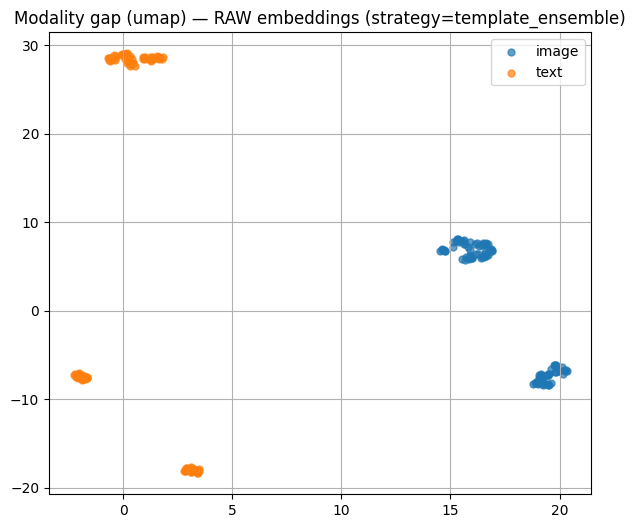

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


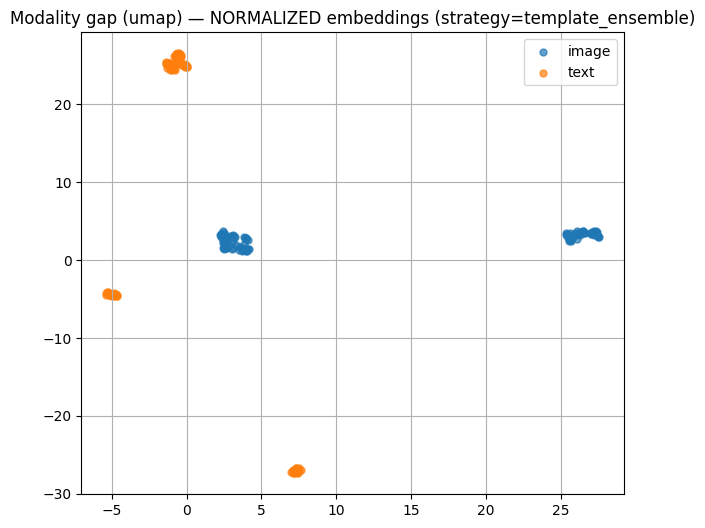

In [17]:
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False
METHOD = "umap"
stack_raw = torch.cat([img_gap_raw, txt_gap_raw], dim=0).numpy()
modality = ["image"] * N_GAP + ["text"] * N_GAP
Z_raw = reduce_2d(stack_raw, method=METHOD)
plot_modalities_2d(Z_raw, modality, f"Modality gap ({METHOD}) — RAW embeddings (strategy={GAP_STRATEGY})")

stack_norm = torch.cat([img_gap_norm, txt_gap_norm], dim=0).numpy()
Z_norm = reduce_2d(stack_norm, method=METHOD)
plot_modalities_2d(Z_norm, modality, f"Modality gap ({METHOD}) — NORMALIZED embeddings (strategy={GAP_STRATEGY})")


Procrustes: learned R shape: (512, 512) | scale: 87.80612

=== Zero-shot accuracy AFTER Procrustes (image_feats_norm @ R) ===
[plain_label] aligned top-1 accuracy: 90.65%  |  baseline: 96.25%
[a_photo_of] aligned top-1 accuracy: 94.27%  |  baseline: 97.31%
[template_ensemble] aligned top-1 accuracy: 94.08%  |  baseline: 97.12%


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


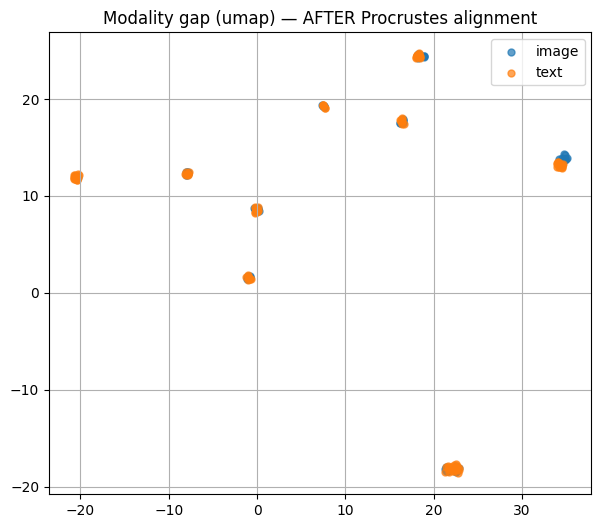


[Gap stats | AFTER alignment]
Paired cosine sim (mean): 0.8780
Centroid cosine sim:      1.0000
Centroid L2 distance:     0.1386


In [18]:
X = img_gap_norm.numpy()
Y = txt_gap_norm.numpy()

R, scale = orthogonal_procrustes(X, Y)
print("\nProcrustes: learned R shape:", R.shape, "| scale:", scale)

R_torch = torch.tensor(R, dtype=torch.float32)
aligned_image_feats = image_feats_norm @ R_torch
print("\n=== Zero-shot accuracy AFTER Procrustes (image_feats_norm @ R) ===")
aligned_results = {}
for name, cfg in PROMPT_STRATEGIES.items():
    text_feats_norm = results[name]["text_feats_norm"]
    acc_aligned = top1_accuracy_from_embeddings(aligned_image_feats, text_feats_norm, y_true)
    aligned_results[name] = acc_aligned
    print(f"[{name}] aligned top-1 accuracy: {acc_aligned*100:.2f}%  |  baseline: {results[name]['acc']*100:.2f}%")


aligned_img_gap = img_gap_norm @ R_torch
stack_aligned = torch.cat([aligned_img_gap, txt_gap_norm], dim=0).numpy()
Z_aligned = reduce_2d(stack_aligned, method=METHOD)
plot_modalities_2d(Z_aligned, modality, f"Modality gap ({METHOD}) — AFTER Procrustes alignment")
paired_simA, cent_cosA, cent_l2A = compute_gap_stats(aligned_img_gap, txt_gap_norm)
print("\n[Gap stats | AFTER alignment]")
print(f"Paired cosine sim (mean): {paired_simA:.4f}")
print(f"Centroid cosine sim:      {cent_cosA:.4f}")
print(f"Centroid L2 distance:     {cent_l2A:.4f}")